# Topology optimization of an MBB beam

## Problem configuration 
The configuration of the problem is defined as a dictionary that is consistent to the format used in [ToPy](https://github.com/williamhunter/topy) for comparison to well established codes.

In [1]:
# The 'classic' 60x20 2d mbb beam, as per Ole Sigmund's 99 line code.
config = {
    "FILT_RAD": 1.5,
    "FXTR_NODE_X": range(1, 22),
    "FXTR_NODE_Y": 1281,
    "LOAD_NODE_Y": 1,
    "LOAD_VALU_Y": -1,
    "NUM_ELEM_X": 60,
    "NUM_ELEM_Y": 20,
    "NUM_ITER": 94,
    "P_FAC": 3.0,
    "VOL_FRAC": 0.5,
}

Using the configuration, we can build the FEM model representing the solution domain.

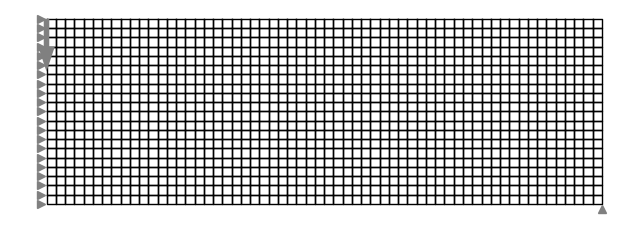

In [2]:
import torch

torch.set_default_dtype(torch.double)

from torchfem import Planar
from torchfem.materials import IsotropicElasticityPlaneStress

# Material model (plane stress)
material = IsotropicElasticityPlaneStress(E=100.0, nu=0.3)

Nx = config["NUM_ELEM_X"]
Ny = config["NUM_ELEM_Y"]

# Create nodes
n1 = torch.linspace(0.0, Nx, Nx + 1)
n2 = torch.linspace(Ny, 0.0, Ny + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="ij"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(Ny):
    for i in range(Nx):
        n0 = j + i * (Ny + 1)
        elements.append([n0, n0 + 1, n0 + Ny + 2, n0 + Ny + 1])
elements = torch.tensor(elements)

model = Planar(nodes, elements, material)

# Load at top
model.forces[torch.tensor(config["LOAD_NODE_Y"]) - 1, 1] = config["LOAD_VALU_Y"]

# Constrained displacement at left end
model.constraints[torch.tensor(config["FXTR_NODE_X"]) - 1, 0] = True
model.constraints[torch.tensor(config["FXTR_NODE_Y"]) - 1, 1] = True


# Plot the domain
model.plot()

## Optimization
We solve the toplogy optimization problem of minimizing compliance for a prescribed volume fraction via optimality conditions. To do so, we first define couple of optimization parameters:

In [3]:
# Initial, minimum, and maximum values of design variables
rho_0 = config["VOL_FRAC"] * torch.ones(len(elements), requires_grad=True)
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = torch.ones_like(rho_0)

# Volume fraction
V_0 = config["VOL_FRAC"] * Nx * Ny

# Analytical gradient of the stiffness matrix
k0 = torch.einsum("i,ijk->ijk", 1.0 / model.thickness, model.k0())

# Move limit for optimality condition algortihm
move = 0.2

# Precompute filter weights
if config["FILT_RAD"] > 0.0:
    ecenters = torch.stack([torch.mean(nodes[e], dim=0) for e in elements])
    dist = torch.cdist(ecenters, ecenters)
    H = config["FILT_RAD"] - dist
    H[dist > config["FILT_RAD"]] = 0.0

This is the actual optimization using optimality conditions. There are two variants:
- `TORCH_SENS = True` uses automatic differentiation to compute the sensitivities $\frac{\partial C}{\partial \rho_i}$ making use of the torch implementation of FEM. 
- `TORCH_SENS = False` uses the well established analytical solution for the sensitivities $$\frac{\partial C}{\partial \rho_i} = -p \rho_i^{p-1} \mathbf{u} \cdot \mathbf{k_0} \cdot \mathbf{u}.$$

In this case, automatic differentiation is approximately 30-50% slower, but it eliminates the need to compute sensitivities. This might be useful, if analytical solutions are not as simple and readily available, as for the archetype topology optimization problem.

In [4]:
from scipy.optimize import bisect
from tqdm import tqdm

rho = [rho_0]
p = config["P_FAC"]

TORCH_SENS = False

# Iterate solutions
for k in tqdm(range(config["NUM_ITER"])):
    # Adjust thickness variables
    model.thickness = rho[k] ** p

    # Compute solution
    u_k, f_k, _, _, _ = model.solve()

    # Evaluation of compliance
    compliance = torch.inner(f_k.ravel(), u_k.ravel())

    if TORCH_SENS:
        # The lazy variant - simply compute the sensitivity of the compliance via
        # automatic differentiation.
        sensitivity = torch.autograd.grad(compliance, rho[k])[0]
    else:
        # Compute analytical sensitivities
        u_j = u_k[elements].reshape(model.n_elem, -1)
        w_k = torch.einsum("...i, ...ij, ...j", u_j, k0, u_j)
        sensitivity = -p * rho[k] ** (p - 1.0) * w_k

    # Filter sensitivities (if r provided)
    if config["FILT_RAD"] > 0.0:
        sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

    # For a certain value of mu, apply the iteration scheme
    def make_step(mu):
        G_k = -sensitivity / mu
        upper = torch.min(rho_max, (1 + move) * rho[k])
        lower = torch.max(rho_min, (1 - move) * rho[k])
        rho_trial = G_k**0.5 * rho[k]
        return torch.maximum(torch.minimum(rho_trial, upper), lower)

    # Constraint function
    def g(mu):
        rho_k = make_step(mu)
        return rho_k.sum() - V_0

    # Find the root of g(mu)
    with torch.no_grad():
        mu = bisect(g, 1e-10, 100.0)

    rho.append(make_step(mu))

100%|██████████| 94/94 [00:02<00:00, 37.23it/s]


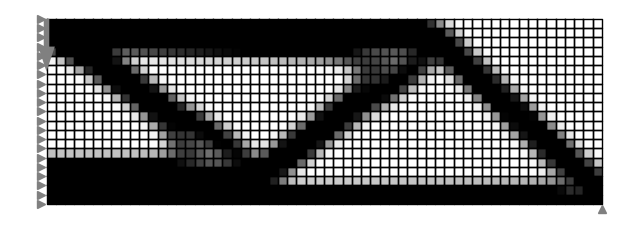

In [5]:
model.plot(element_property=rho[-1], cmap="gray_r")

## Export designs

In [6]:
import numpy as np

with torch.no_grad():
    rho_export = np.array(rho).reshape(len(rho), Ny, Nx)
    np.savez("mbb.npz", rho=rho_export)

# Topology optimization of an cantilever beam in 3D 

We start by defining the base problem without considering the optimization yet.

In [7]:
from torchfem import Solid
from torchfem.materials import IsotropicElasticity3D

# Material model
material = IsotropicElasticity3D(E=100.0, nu=0.3)

Nx = 20
Ny = 10
Nz = 15

# Create nodes
n1 = torch.linspace(0.0, Nx, Nx + 1)
n2 = torch.linspace(0.0, Ny, Ny + 1)
n3 = torch.linspace(0.0, Nz, Nz + 1)
n1, n2, n3 = torch.stack(torch.meshgrid(n1, n2, n3, indexing="ij"))
nodes = torch.stack([n1.ravel(), n2.ravel(), n3.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            n0 = i * (Ny + 1) * (Nz + 1) + j * (Nz + 1) + k
            n1 = n0 + (Ny + 1) * (Nz + 1)
            n2 = n1 + (Nz + 1)
            n3 = n0 + (Nz + 1)
            n4 = n0 + 1
            n5 = n1 + 1
            n6 = n2 + 1
            n7 = n3 + 1
            elements.append([n0, n1, n2, n3, n4, n5, n6, n7])
elements = torch.tensor(elements)

model = Solid(nodes, elements, material)

# Load at tip
tip = nodes[:, 0] == Nx
bottom = nodes[:, 2] == 0
model.forces[tip & bottom, 2] = -1.0
model.forces[tip & bottom & (nodes[:, 1] == 0), 2] = -0.5
model.forces[tip & bottom & (nodes[:, 1] == Ny), 2] = -0.5

# Constrained displacement at left end
model.constraints[nodes[:, 0] == 0.0, :] = True

# Solve
u, f, sigma, epsilon, state = model.solve()

# Plot
model.plot(u=u, node_property={"U": u})

Widget(value='<iframe src="http://localhost:55925/index.html?ui=P_0x127630910_0&reconnect=auto" class="pyvista…

## Optimization parameters 
We define the optimization parameters, i.e. the volume fraction, the penalization factor, the move limit, the filter radius, and the number of iterations.

In [8]:
volfrac = 0.5
p = 3
move = 0.2
R = 1.5
TORCH_SENS = False

In [9]:
# Initial, minimum, and maximum values of design variables
rho_0 = volfrac * torch.ones(len(elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = torch.ones_like(rho_0)

# Volume fraction
V_0 = volfrac * Nx * Ny * Nz

# Analytical gradient of the stiffness matrix
k0 = model.k0()
C0 = model.material.C.clone()

# Precompute filter weights
ecenters = torch.stack([torch.mean(nodes[e], dim=0) for e in elements])
dist = torch.cdist(ecenters, ecenters)
H = R - dist
H[dist > R] = 0.0

## Optimization with optimality constraints. 

This may take a minute to run.

In [10]:
rho = [rho_0]

# Iterate solutions
for k in tqdm(range(20)):
    # Adjust thickness variables
    model.material.C = torch.einsum("j,jkl->jkl", rho[k] ** p, C0)

    # Compute solution
    u_k, f_k, _, _, _ = model.solve()

    # Evaluation of compliance
    compliance = torch.inner(f_k.ravel(), u_k.ravel())

    # Compute analytical sensitivities
    u_j = u_k[elements].reshape(model.n_elem, -1)
    w_k = torch.einsum("...i, ...ij, ...j", u_j, k0, u_j)
    sensitivity = -p * rho[k] ** (p - 1.0) * w_k

    # Filter sensitivities (if r provided)
    sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

    # For a certain value of mu, apply the iteration scheme
    def make_step(mu):
        G_k = -sensitivity / mu
        upper = torch.min(rho_max, (1 + move) * rho[k])
        lower = torch.max(rho_min, (1 - move) * rho[k])
        rho_trial = G_k**0.5 * rho[k]
        return torch.maximum(torch.minimum(rho_trial, upper), lower)

    # Constraint function
    def g(mu):
        rho_k = make_step(mu)
        return rho_k.sum() - V_0

    # Find the root of g(mu)
    with torch.no_grad():
        mu = bisect(g, 1e-10, 100.0)

    rho.append(make_step(mu))

100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


In [11]:
from torchfem.io import export_mesh

export_mesh(model, "result.vtu", elem_data={"rho": [rho[-1]]})